In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt


In [2]:
E_baseline = 3.0   # Hz (example value)
E_amp = 14.6  # Hz (example)
I_baseline = 63.3 #1000 #200.0   # Hz (example)
I_amp = 0 #2000 #600.0    # Hz (example)

# E_baseline = 3.0   # Hz (example value)
# E_amp = 10  # Hz (example)
# I_baseline = 25. #1000 #200.0   # Hz (example)
# I_amp = 0 #2000 #600.0    # Hz (example)


g_NMDA = 0.4 * 3 * 3 * nS  # example conductance for NMDA
N_E_bg = 800  # Number of excitatory background neurons
N_I_bg = 200   # Number of inhibitory background neurons

E_ext = 20.0 # Externally applied excitatory conductance (to be tuned)
g_AMPA_ext = 0.4 * 150 * nS  # Externally applied AMPA conductance (to be tuned)
N_E_ext = 1

# OU process parameters for background current
tau_ou = 2 * ms  # OU time constant
I_bg_mean = 0 * pA  # Mean background current (to be tuned)
I_bg_sigma = 0 * pA  # Standard deviation of OU noise (to be tuned)
I_deps = np.linspace(0, 1000, 6)

duration = 2100.0  # Total simulation duration in ms
N_neurons = 50  # Number of neurons to simulate

In [3]:
from scipy import signal
def butter_bandpass_filter(data, cutoffs, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoffs = np.array(cutoffs) / nyq
    # Get the filter coefficients 
    b, a = signal.butter(order, normal_cutoffs, btype='band')
    y = signal.filtfilt(b, a, data)
    return y

def calculate_theta_amplitude(Vm, dt=0.1, axtemp=[]):
    # bandpass filter the Vmtemp between 4 and 12 Hz
    Vm_theta = butter_bandpass_filter(Vm, [7, 9], 1000/dt, order=3)

    # do hilbert transform to get the amplitude of the theta oscillation
    Vm_theta_hilbert = np.abs(signal.hilbert(Vm_theta))

    if axtemp:
        axtemp.plot(Vm, label='Raw trace')
        axtemp.plot(Vm_theta, label='Theta band')
        axtemp.plot(Vm_theta_hilbert, label='Theta amplitude')
    
    return np.mean(Vm_theta_hilbert)


def pregen_spikes(
    E_baseline, E_amp, I_baseline, I_amp, f,
    duration_ms, dt_ms,
    N_neurons, N_E_bg, N_I_bg,
    E_ext_hz, N_E_ext,
    seed=12345
):
    """
    Return dict with keys 'exc','inh','ext', each a tuple (indices, times)
    suitable for SpikeGeneratorGroup. Times are with Brian2 units (ms).
    """
    rng = np.random.default_rng(seed)

    # Time grid
    t = np.arange(0.0, duration_ms, dt_ms)  # ms
    nT = t.size
    dt_s = dt_ms * 1e-3  # s

    # Theta-rectified rate functions (Hz)
    s = np.sin(2*np.pi*f*(t/1000.0))
    rect = (s + 1)/2

    r_exc = (E_baseline + E_amp * rect)  # Hz
    r_inh = (I_baseline + I_amp * rect)  # Hz
    r_ext = np.full_like(t, E_ext_hz, dtype=float)  # constant Hz

    # Probabilities per bin (Bernoulli approximation to inhomog. Poisson)
    p_exc = np.clip(r_exc * dt_s, 0.0, 0.05)  # safety cap
    p_inh = np.clip(r_inh * dt_s, 0.0, 0.05)
    p_ext = np.clip(r_ext * dt_s, 0.0, 0.05)

    # Helper to sample a pool with identical rate(t) for all sources
    def sample_pool(N_sources, p_t):
        # Draw uniform in [0,1), events wherever U < p_t at each time bin
        U = rng.random((N_sources, nT))
        events = (U < p_t[None, :])
        # Indices
        src_idx, t_idx = np.nonzero(events)
        # Convert to global indices and times with a tiny within-bin jitter
        # Jitter ensures times are not locked to grid but stays deterministic.
        jitter = rng.random(t_idx.size) * dt_ms  # ms
        times_ms = t[t_idx] + jitter
        return src_idx.astype(int), times_ms * ms

    # Background excitatory
    N_exc_sources = N_neurons * N_E_bg
    exc_i, exc_t = sample_pool(N_exc_sources, p_exc)

    # Background inhibitory
    N_inh_sources = N_neurons * N_I_bg
    inh_i, inh_t = sample_pool(N_inh_sources, p_inh)

    # External excitatory
    N_ext_sources = N_neurons * N_E_ext
    ext_i, ext_t = sample_pool(N_ext_sources, p_ext)

    # Map sources to (post-syn j) ranges:
    # We keep the same contiguous block layout your code uses:
    #   for neuron j: presyn i in [j*block, (j+1)*block)
    # This is already satisfied by our source indexing (0..N_sources-1) if
    # you connect with identical slicing in Synapses.

    return {
        'exc': (exc_i, exc_t, N_exc_sources),
        'inh': (inh_i, inh_t, N_inh_sources),
        'ext': (ext_i, ext_t, N_ext_sources),
    }

def run_simulation(
    E_baseline, E_amp, I_baseline, I_amp, I_dep,
    f=8.0, dt=0.1, N_neurons=50, theta_freq=[7, 9], axs=None,
    duration=2100.0,
    g_NMDA=0.4 * 3 * nS,
    g_AMPA= 1 * nS,
    g_GABA= 3 * nS,
    E_ext=5.0,
    g_AMPA_ext=10.0 * nS,
    N_E_ext=1,
    N_E_bg=800, N_I_bg=200,
    tau_AMPA=2.0 * ms,
    tau_NMDA_rise=2.0 * ms, tau_NMDA_decay=100.0 * ms, alpha=0.5 / ms, Mg2=1.0,
    tau_GABA=10.0 * ms,
    I_bg_mean=0 * pA, I_bg_sigma=0 * pA, tau_ou=5.0 * ms,
    record_presyn=False,
    pregen=None  # <---- NEW: pass dict from pregen_spikes()
):
    start_scope()

    # Timed rates only needed for on-the-fly Poisson; kept for compatibility
    t_array = np.arange(0, duration, dt)
    def rate_exc(t_ms):
        s = np.sin(2 * np.pi * f * (t_ms / 1000.0))
        return E_baseline + E_amp * (s + 1)/2
    def rate_inh(t_ms):
        s = np.sin(2 * np.pi * f * (t_ms / 1000.0))
        return I_baseline + I_amp * (s + 1)/2
    rate_exc_array = TimedArray(rate_exc(t_array) * Hz, dt=dt * ms)
    rate_inh_array = TimedArray(rate_inh(t_array) * Hz, dt=dt * ms)

    # --- Membrane / LIF params ---
    V_L = -60. * mV
    V_thr_E = -50. * mV
    V_reset = -55. * mV
    V_E = 0. * mV
    V_I = -80. * mV
    C_m_E = 0.25 * nF
    g_m_E = 25 * nS
    tau_rp_E = 2. * ms

    eqs_E = '''
    dv / dt = ( - g_m_E * (v - V_L) - I_syn + I_dep + I_bg ) / C_m_E : volt (unless refractory)
    I_syn = I_AMPA_bg + I_AMPA_ext + I_NMDA + I_GABA : amp
    I_AMPA_bg = g_AMPA * s_AMPA * (v - V_E) : amp
    ds_AMPA / dt = - s_AMPA / tau_AMPA : 1
    I_AMPA_ext = g_AMPA_ext * s_AMPA_ext * (v - V_E) : amp
    ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
    I_NMDA = g_NMDA * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
    s_NMDA_tot : 1
    I_GABA = g_GABA * s_GABA * (v - V_I) : amp
    ds_GABA / dt = - s_GABA / tau_GABA : 1
    I_dep : amp (constant)
    dI_bg / dt = (I_bg_mean - I_bg) / tau_ou + I_bg_sigma * sqrt(2 / tau_ou) * xi : amp
    '''
    P_E = NeuronGroup(N_neurons, eqs_E, threshold='v > V_thr_E', reset='v = V_reset',
                      refractory=tau_rp_E, method='euler')
    P_E.v = V_L
    P_E.I_dep = I_dep
    P_E.I_bg = I_bg_mean

    # --- Presynaptic sources: SpikeGeneratorGroup when pregenerated ---
    if pregen is not None:
        exc_i, exc_t, N_exc_sources = pregen['exc']
        inh_i, inh_t, N_inh_sources = pregen['inh']
        ext_i, ext_t, N_ext_sources = pregen['ext']

        P_exc = SpikeGeneratorGroup(N_exc_sources, exc_i, exc_t, sorted=False)
        P_inh = SpikeGeneratorGroup(N_inh_sources, inh_i, inh_t, sorted=False)
        P_ext = SpikeGeneratorGroup(N_ext_sources, ext_i, ext_t, sorted=False)
    else:
        # Fallback: original on-the-fly Poisson (not identical across runs)
        P_exc = PoissonGroup(N_neurons * N_E_bg, rates='rate_exc_array(t)')
        P_inh = PoissonGroup(N_neurons * N_I_bg, rates='rate_inh_array(t)')
        P_ext = PoissonGroup(N_neurons * N_E_ext, rates=E_ext * Hz)

    # --- Excitatory (AMPA+NMDA) bg synapses ---
    eqs_glut = '''
    s_NMDA_tot_post = w * s_NMDA : 1 (summed)
    ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
    dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
    w : 1
    '''
    on_pre_glut = '''
    s_AMPA_post += w
    x += 1
    '''
    C_exc = Synapses(P_exc, P_E, model=eqs_glut, on_pre=on_pre_glut, method='euler')
    for j in range(N_neurons):
        C_exc.connect(i=np.arange(j * N_E_bg, (j + 1) * N_E_bg), j=j)
    C_exc.w = 1.0

    # --- Inhibitory (GABA_A) synapses ---
    C_inh = Synapses(P_inh, P_E, on_pre='s_GABA_post += 1', method='euler')
    for j in range(N_neurons):
        C_inh.connect(i=np.arange(j * N_I_bg, (j + 1) * N_I_bg), j=j)

    # --- External AMPA synapses ---
    C_ext = Synapses(P_ext, P_E, on_pre='s_AMPA_ext_post += w_ext', model='w_ext : 1', method='euler')
    for j in range(N_neurons):
        C_ext.connect(i=np.arange(j * N_E_ext, (j + 1) * N_E_ext), j=j)
    C_ext.w_ext = 1.0

    # --- Monitors (unchanged) ---
    mon_v = StateMonitor(P_E, 'v', record=True)
    spikes = SpikeMonitor(P_E)

    sp_exc = SpikeMonitor(P_exc, record=record_presyn)
    sp_inh = SpikeMonitor(P_inh, record=record_presyn)
    sp_ext = SpikeMonitor(P_ext, record=record_presyn)

    mon_I_AMPA_bg = StateMonitor(P_E, 'I_AMPA_bg', record=True)
    mon_I_AMPA_ext = StateMonitor(P_E, 'I_AMPA_ext', record=True)
    mon_I_NMDA = StateMonitor(P_E, 'I_NMDA', record=True)
    mon_I_GABA = StateMonitor(P_E, 'I_GABA', record=True)
    mon_I_bg = StateMonitor(P_E, 'I_bg', record=True)

    # --- Run ---
    run(duration * ms)

    mask_indices = [500, duration-500]  # indices for 500 ms to duration-500 ms

    # --- Analysis window and returns (same as your original) ---
    t_mask = (mon_v.t / ms >= mask_indices[0]) & (mon_v.t / ms <= mask_indices[1])

    sp_exc_t = sp_exc.t / ms if record_presyn else np.array([])
    sp_exc_i = sp_exc.i if record_presyn else np.array([], dtype=int)
    exc_mask = (sp_exc_t >= mask_indices[0]) & (sp_exc_t <= mask_indices[1]) if record_presyn else np.array([], dtype=bool)

    sp_inh_t = sp_inh.t / ms if record_presyn else np.array([])
    sp_inh_i = sp_inh.i if record_presyn else np.array([], dtype=int)
    inh_mask = (sp_inh_t >= mask_indices[0]) & (sp_inh_t <= mask_indices[1]) if record_presyn else np.array([], dtype=bool)

    sp_ext_t = sp_ext.t / ms if record_presyn else np.array([])
    sp_ext_i = sp_ext.i if record_presyn else np.array([], dtype=int)
    ext_mask = (sp_ext_t >= mask_indices[0]) & (sp_ext_t <= mask_indices[1]) if record_presyn else np.array([], dtype=bool)

    spikes_t = spikes.t / ms
    spikes_i = spikes.i
    spikes_mask = (spikes_t >= mask_indices[0]) & (spikes_t <= mask_indices[1])

    Vm = mon_v.v[:, :] / mV

    currents = [
        (mon_I_AMPA_bg.I_AMPA_bg[:, :] / pA, 'AMPA (bg) Current', 'green', -1),
        (mon_I_NMDA.I_NMDA[:, :] / pA, 'NMDA Current', 'blue', -1),
        (mon_I_GABA.I_GABA[:, :] / pA, 'GABA Current', 'red', 1),
        (mon_I_bg.I_bg[:, :] / pA, 'Background Current', 'orange', 1),
        (mon_I_AMPA_ext.I_AMPA_ext[:, :] / pA, 'AMPA_ext Current', 'darkgreen', -1),
    ]

    # Theta-bandpass versions
    theta_currents = []
    for curr_data, label, color, sign in currents:
        filtered_curr = np.zeros_like(curr_data)
        for i in range(len(curr_data)):
            filtered_curr[i] = butter_bandpass_filter(curr_data[i], theta_freq, 1000/dt, order=1)
        theta_currents.append((filtered_curr, label, color, sign))

    # Firing rates per neuron in the analysis window
    start_time = mask_indices[0] * ms
    end_time = mask_indices[1] * ms
    mask = (spikes.t >= start_time) & (spikes.t <= end_time)
    firing_rates = np.array([np.sum(mask & (spikes.i == i)) / ((end_time - start_time) / second)
                             for i in range(N_neurons)])

    # Theta for Vm
    theta_Vm = np.zeros_like(Vm)
    for i in range(len(Vm)):
        theta_Vm[i] = butter_bandpass_filter(Vm[i], theta_freq, 1000/dt, order=1)

    theta_amplitude_Vm = np.mean(np.abs(signal.hilbert(theta_Vm[:,t_mask])), axis=1)
    theta_amplitude_Iampa_bg = np.mean(np.abs(signal.hilbert(theta_currents[0][0][:,t_mask])), axis=1)
    theta_amplitude_Inmda = np.mean(np.abs(signal.hilbert(theta_currents[1][0][:,t_mask])), axis=1)
    theta_amplitude_Igaba = np.mean(np.abs(signal.hilbert(theta_currents[2][0][:,t_mask])), axis=1)
    theta_amplitude_Iampa_ext = np.mean(np.abs(signal.hilbert(theta_currents[3][0][:,t_mask])), axis=1)  # NEW

    return (
        # presyn rasters
        sp_exc_t, sp_exc_i, exc_mask,
        sp_inh_t, sp_inh_i, inh_mask,
        sp_ext_t, sp_ext_i, ext_mask,    # NEW
        # postsyn
        spikes_t, spikes_i, spikes_mask,
        Vm, currents, theta_Vm, theta_currents, firing_rates,
        # theta amplitudes
        theta_amplitude_Vm, theta_amplitude_Iampa_bg, theta_amplitude_Iampa_ext,
        theta_amplitude_Inmda, theta_amplitude_Igaba
    )

In [4]:
def plot_results(sp_exc_t, sp_exc_i, exc_mask, sp_inh_t, sp_inh_i, inh_mask, spikes_t, spikes_i, spikes_mask, Vm, currents, axs, plotcolor='gray'):
    V_thr_E = -50. * mV
    # Voltage (mean ± std across 50 neurons)
    mean_v = np.mean(Vm, axis=0)
    std_v = np.std(Vm, axis=0)/ np.sqrt(len(Vm))  # std across neurons
    axs[0].plot(mean_v, color=plotcolor)
    axs[0].fill_between(np.arange(len(mean_v)), mean_v - std_v, mean_v + std_v, color=plotcolor, alpha=0.3)
    axs[0].axhline(V_thr_E / mV, color='k', linestyle='--', label='Threshold')
    axs[0].set_title('Average E Neuron Voltage (± std)')
    axs[0].set_ylabel('Voltage (mV)')

    Iampa_gaba = np.mean(currents[0][0], axis=0) + np.mean(currents[2][0], axis=0)
    Inmda_gaba = np.mean(currents[1][0], axis=0) + np.mean(currents[2][0], axis=0)
    I_bg_mean = np.mean(currents[3][0], axis=0)
    for idx, (curr_data, label, color, sign) in enumerate(currents):
        mean_curr = np.mean(-curr_data, axis=0)
        std_curr = np.std(-curr_data, axis=0) / np.sqrt(N_neurons)  # std across neurons
        axs[1 + idx].plot(mean_curr , color=plotcolor)
        axs[1 + idx].fill_between(np.arange(len(mean_curr)),  (mean_curr - std_curr), (mean_curr + std_curr), color=plotcolor, alpha=0.3)
        axs[1 + idx].set_title(f'Average {label} (± std)')
        axs[1 + idx].set_ylabel('Current (pA)')

    axs[-2].plot(I_bg_mean, color=plotcolor, label='I_AMPA + I_GABA')
    axs[-2].set_title('I_AMPA + I_GABA')

    axs[-1].plot(-Inmda_gaba, color=plotcolor, label='I_NMDA + I_GABA')
    axs[-1].set_title('I_NMDA + I_GABA')
    
    mean_curr_AMPA = np.mean(currents[0][0], axis=0)
    mean_curr_NMDA = np.mean(currents[1][0], axis=0)
    mean_curr_GABA = np.mean(currents[2][0], axis=0)    

    return mean_v, mean_curr_AMPA, mean_curr_NMDA, mean_curr_GABA

def plot_theta_results(Vm, currents, theta_Vm, theta_currents, axs, plotcolor='gray'):

    # Voltage (mean ± std across 50 neurons)
    mean_theta_Vm = np.mean(theta_Vm, axis=0)
    std_theta_Vm = np.std(theta_Vm, axis=0) / np.sqrt(len(theta_Vm))  # std across neurons
    axs[0].plot(mean_theta_Vm, color=plotcolor)
    axs[0].fill_between(np.arange(len(mean_theta_Vm)), mean_theta_Vm - std_theta_Vm, mean_theta_Vm + std_theta_Vm, color=plotcolor, alpha=0.3)
    #axs[0].axhline(V_thr_E / mV, color='k', linestyle='--', label='Threshold')
    axs[0].set_title('Average E Neuron Voltage (± std)')
    axs[0].set_ylabel('Voltage (mV)')

    Iampa_gaba = np.mean(theta_currents[0][0], axis=0) + np.mean(theta_currents[2][0], axis=0)
    Inmda_gaba = np.mean(theta_currents[1][0], axis=0) + np.mean(theta_currents[2][0], axis=0)
    
    for idx, (curr_data, label, color, sign) in enumerate(theta_currents):
        mean_curr = np.mean(-curr_data, axis=0)
        std_curr = np.std(-curr_data, axis=0) / np.sqrt(N_neurons)  # std across neurons
        axs[1 + idx].plot(mean_curr , color=plotcolor)
        axs[1 + idx].fill_between(np.arange(len(mean_curr)),  (mean_curr - std_curr), (mean_curr + std_curr), color=plotcolor, alpha=0.3)
        axs[1 + idx].set_title(f'Average {label} (± std)')
        axs[1 + idx].set_ylabel('Current (pA)')
        
    # calculate theta amplitude for theta_currents
    theta_amplitude_Vm = [np.mean(np.abs(signal.hilbert(theta_Vm[i]))) for i in range(len(theta_Vm))]
    theta_amplitude_Iampa = [np.mean(np.abs(signal.hilbert(theta_currents[0][0][i]))) for i in range(len(theta_currents[0][0]))]
    theta_amplitude_Inmda = [np.mean(np.abs(signal.hilbert(theta_currents[1][0][i]))) for i in range(len(theta_currents[1][0]))]
    theta_amplitude_GABA = [np.mean(np.abs(signal.hilbert(theta_currents[2][0][i]))) for i in range(len(theta_currents[2][0]))]

    axs[-2].plot(-Iampa_gaba, color=plotcolor, label='I_AMPA + I_GABA')
    axs[-2].set_title('I_AMPA + I_GABA')

    axs[-1].plot(-Inmda_gaba, color=plotcolor, label='I_NMDA + I_GABA')
    axs[-1].set_title('I_NMDA + I_GABA')


    return theta_amplitude_Vm,theta_amplitude_Iampa, theta_amplitude_Inmda, theta_amplitude_GABA



WARNING    'I_dep' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0. * amp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'synapses', but also exists in the run namespace with the value 0.1. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_dep' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 200. * pamp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_dep' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 0.4 * namp. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'I_dep' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value

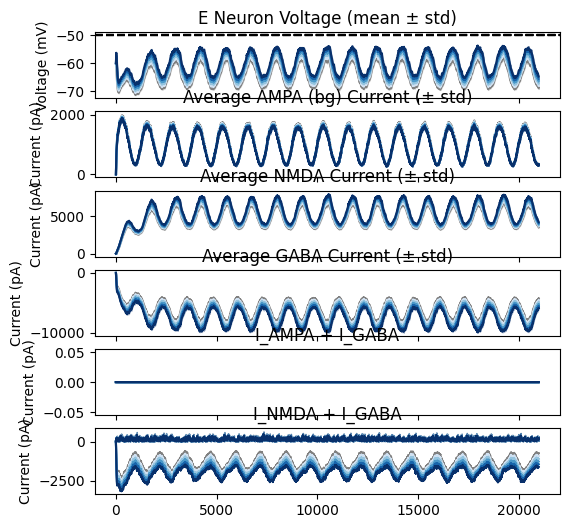

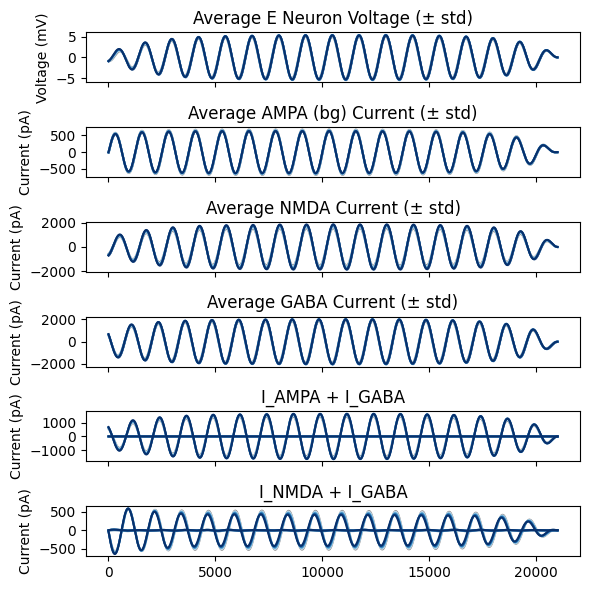

<Figure size 640x480 with 0 Axes>

Spontaneous firing rates (Hz): 3.4 ± 2.444829254292542


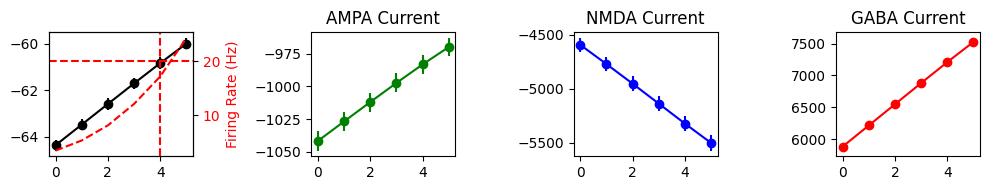

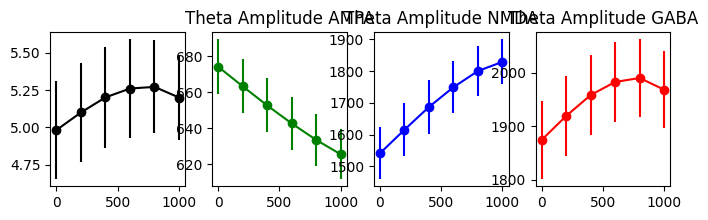

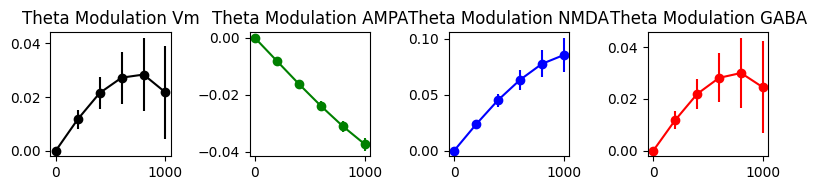

Inputs match for I_dep index 1
Inputs match for I_dep index 2
Inputs match for I_dep index 3
Inputs match for I_dep index 4
Inputs match for I_dep index 5


In [5]:
 #np.array([0, 300, 650]) # Different depolarization currents in pA
#I_deps = [0, 5000, 10000]  # Different depolarization currents in pA
I_dep_values = [I_dep * pA for I_dep in I_deps]

dt = 0.1



v_values = []
curr_AMPA_values = []
curr_NMDA_values = []
curr_GABA_values = []

# create graded colors from gray to blue
colors = plt.cm.Blues(np.linspace(0, 1, len(I_dep_values)))
colors[0] = [0.5, 0.5, 0.5, 1]  # Set the first color to gray

fig, axs = plt.subplots(6, 1, figsize=(6,6), sharex=True)

fig2, axs2 = plt.subplots(6, 1, figsize=(6,6), sharex=True)

v_values = []
curr_AMPA_values = []
curr_NMDA_values = []
curr_GABA_values = []
curr_bg_values = []

theta_amplitude_Vm_values = []
theta_amplitude_Iampa_values = []
theta_amplitude_Inmda_values = []
theta_amplitude_GABA_values = []

firing_rates_values = []

# Before the loop, initialize lists
exc_t_list = []
exc_i_list = []
inh_t_list = []
inh_i_list = []

Vms = []
theta_Vms = []
spikes_all = []

# --- One-time pregeneration using your sim settings ---
pregen = pregen_spikes(
    E_baseline=E_baseline, E_amp=E_amp,
    I_baseline=I_baseline, I_amp=I_amp, f=8.0,
    duration_ms=duration, dt_ms=dt,
    N_neurons=N_neurons, N_E_bg=N_E_bg, N_I_bg=N_I_bg,
    E_ext_hz=E_ext, N_E_ext=N_E_ext,
    seed=42  # set once; identical across all runs
)

# --- Now loop with identical presyn for all I_dep ---
for ind, I_dep in enumerate(I_dep_values):
    seed = 0
    outputs = run_simulation(
        E_baseline=E_baseline, E_amp=E_amp,
        I_baseline=I_baseline, I_amp=I_amp,
        I_dep=I_dep, f=8.0, dt=dt, g_NMDA=g_NMDA, N_neurons=N_neurons,
        N_E_bg=N_E_bg, N_I_bg=N_I_bg,
        E_ext=E_ext, g_AMPA_ext=g_AMPA_ext, N_E_ext=N_E_ext,
        I_bg_mean=I_bg_mean, I_bg_sigma=I_bg_sigma,
        pregen=pregen,                 # <---- key line
        record_presyn=True             # if you want to verify equality
    )

    # Unpack outputs
    (sp_exc_t, sp_exc_i, exc_mask,
    sp_inh_t, sp_inh_i, inh_mask,
    sp_ext_t, sp_ext_i, ext_mask,          # NEW block (external AMPA presyn)
    spikes_t, spikes_i, spikes_mask,
    Vm, currents, theta_Vm, theta_currents, firing_rates,
    theta_amplitude_Vm, 
    theta_amplitude_Iampa,               # AMPA (background) theta amplitude
    theta_amplitude_Iampa_ext,              # AMPA (external) theta amplitude
    theta_amplitude_Inmda, 
    theta_amplitude_Igaba) = outputs
    mean_v = np.mean(Vm, axis=1)
    v_values.append(mean_v)
    Vms.append(Vm)
    theta_Vms.append(theta_Vm)
    spike_trains = [spikes_t[spikes_mask & (spikes_i == n)] for n in range(N_neurons)]
    spikes_all.append(spike_trains)
    curr_AMPA_values.append(np.mean(currents[0][0], axis=1))
    curr_NMDA_values.append(np.mean(currents[1][0], axis=1))
    curr_GABA_values.append(np.mean(currents[2][0], axis=1))
    curr_bg_values.append(np.mean(currents[3][0], axis=1))
    firing_rates_values.append(firing_rates)

    plot_results(sp_exc_t, sp_exc_i, exc_mask, sp_inh_t, sp_inh_i, inh_mask,
                 spikes_t, spikes_i, spikes_mask, Vm,
                 currents=currents, axs=axs, plotcolor=colors[ind])
    plot_theta_results(Vm, currents, theta_Vm, theta_currents, axs2, plotcolor=colors[ind])
    theta_amplitude_Vm_values.append(theta_amplitude_Vm)
    theta_amplitude_Iampa_values.append(theta_amplitude_Iampa)
    theta_amplitude_Inmda_values.append(theta_amplitude_Inmda)
    theta_amplitude_GABA_values.append(theta_amplitude_Igaba)

    # Inside the loop, after run_simulation()
    exc_t_list.append(sp_exc_t)
    exc_i_list.append(sp_exc_i)
    inh_t_list.append(sp_inh_t)
    inh_i_list.append(sp_inh_i)

# show figures
axs[0].set_title('E Neuron Voltage (mean ± std)')
plt.tight_layout()
plt.show()

axs2[0].set_title('Theta E Neuron Voltage (mean ± std)')
plt.tight_layout()
plt.show()

print('Spontaneous firing rates (Hz):', np.mean(firing_rates_values[0]), '±', np.std(firing_rates_values[0]))

fig, axs = plt.subplots(1, 4, figsize=(10,2), sharex=True)
axs[0].errorbar(np.arange(len(I_deps)), np.mean(v_values, axis=1), yerr=np.std(v_values, axis=1), fmt='o-', color='k')
# twin x-axis for I_deps, show firing rates
ax2 = axs[0].twinx()
ax2.plot(np.arange(len(I_deps)), np.mean(firing_rates_values, axis=1), 'r--', label='Firing Rate (Hz)')

# from the np.mean(firing_rates_values, axis=1), infer the I_dep needed for reaching firing rate of 20Hz
FR_target = 20
# interpolate to find the index where firing rate is closest to 20Hz
closest_index = np.argmin(np.abs(np.mean(firing_rates_values, axis=1) - FR_target))
I_dep_target = I_deps[closest_index]
ax2.axhline(FR_target, color='r', linestyle='--', label='Target Firing Rate (20 Hz)')
ax2.axvline(closest_index, color='r', linestyle='--', label=f'I_dep for 20 Hz: {I_dep_target} pA')

ax2.set_ylabel('Firing Rate (Hz)', color='r')
# ax2 ytick labels in red
ax2.tick_params(axis='y', labelcolor='r')

axs[1].errorbar(np.arange(len(I_deps)), np.mean(curr_AMPA_values, axis=1), yerr=np.std(curr_AMPA_values, axis=1), fmt='o-', color='g', label='AMPA')
axs[1].set_title('AMPA Current')

axs[2].errorbar(np.arange(len(I_deps)), np.mean(curr_NMDA_values, axis=1), yerr=np.std(curr_NMDA_values, axis=1), fmt='o-', color='b', label='NMDA')
axs[2].set_title('NMDA Current')

axs[3].errorbar(np.arange(len(I_deps)), np.mean(curr_GABA_values, axis=1), yerr=np.std(curr_GABA_values, axis=1), fmt='o-', color='r', label='GABA')
axs[3].set_title('GABA Current')

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 4, figsize=(8,2), sharex=True)
axs[0].errorbar(I_deps, np.mean(theta_amplitude_Vm_values, axis=1), yerr=np.std(theta_amplitude_Vm_values, axis=1), fmt='o-', color='k')

axs[1].errorbar(I_deps, np.mean(theta_amplitude_Iampa_values, axis=1), yerr=np.std(theta_amplitude_Iampa_values, axis=1), fmt='o-', color='g', label='AMPA')
axs[1].set_title('Theta Amplitude AMPA')
axs[2].errorbar(I_deps, np.mean(theta_amplitude_Inmda_values, axis=1), yerr=np.std(theta_amplitude_Inmda_values, axis=1), fmt='o-', color='b', label='NMDA')
axs[2].set_title('Theta Amplitude NMDA')
axs[3].errorbar(I_deps, np.mean(theta_amplitude_GABA_values, axis=1), yerr=np.std(theta_amplitude_GABA_values, axis=1), fmt='o-', color='r', label='GABA')
axs[3].set_title('Theta Amplitude GABA')
 
plt.show()

# calculate theta modulation 

def calculate_theta_modulation(theta_data):
    theta_data = np.array(theta_data)
    theta_modulation = []
    theta_spon = theta_data[0]  # baseline theta amplitude
    for data in theta_data:
        theta_modulation.append((data - theta_spon) / (data + theta_spon))
    return theta_modulation

theta_modulation_Vm = calculate_theta_modulation(theta_amplitude_Vm_values)
theta_modulation_Iampa = calculate_theta_modulation(theta_amplitude_Iampa_values)
theta_modulation_Inmda = calculate_theta_modulation(theta_amplitude_Inmda_values)
theta_modulation_GABA = calculate_theta_modulation(theta_amplitude_GABA_values)

fig, axs = plt.subplots(1, 4, figsize=(8,2), sharex=True)
axs[0].errorbar(I_deps, np.mean(theta_modulation_Vm, axis=1), yerr=np.std(theta_modulation_Vm, axis=1), fmt='o-', color='k', label='Vm')
axs[0].set_title('Theta Modulation Vm')
axs[1].errorbar(I_deps, np.mean(theta_modulation_Iampa, axis=1), yerr=np.std(theta_modulation_Iampa, axis=1), fmt='o-', color='g', label='AMPA')
axs[1].set_title('Theta Modulation AMPA')
axs[2].errorbar(I_deps, np.mean(theta_modulation_Inmda, axis=1), yerr=np.std(theta_modulation_Inmda, axis=1), fmt='o-', color='b', label='NMDA')
axs[2].set_title('Theta Modulation NMDA')
axs[3].errorbar(I_deps, np.mean(theta_modulation_GABA, axis=1), yerr=np.std(theta_modulation_GABA, axis=1), fmt='o-', color='r', label='GABA')
axs[3].set_title('Theta Modulation GABA')
plt.tight_layout()
plt.show()

# After the loop, add verification
for i in range(1, len(exc_t_list)):
    if not (np.array_equal(exc_t_list[0], exc_t_list[i]) and 
            np.array_equal(exc_i_list[0], exc_i_list[i]) and 
            np.array_equal(inh_t_list[0], inh_t_list[i]) and 
            np.array_equal(inh_i_list[0], inh_i_list[i])):
        print(f"Inputs differ for I_dep index {i}")
    else:
        print(f"Inputs match for I_dep index {i}")

In [6]:
results_to_save = {
    # Parameters
    'I_deps': I_deps,
    
    'firing_rates_all': firing_rates_values,

    # Mean values across neurons (used in some plots)
    'mean_v_traces': v_values,
    'mean_curr_AMPA': curr_AMPA_values,
    'mean_curr_NMDA': curr_NMDA_values,
    'mean_curr_GABA': curr_GABA_values,
    
    # Theta amplitude results
    'theta_amp_Vm': theta_amplitude_Vm_values,
    'theta_amp_Iampa': theta_amplitude_Iampa_values,
    'theta_amp_Inmda': theta_amplitude_Inmda_values,
    'theta_amp_GABA': theta_amplitude_GABA_values,
    
    # Theta modulation results
    'theta_mod_Vm': theta_modulation_Vm,
    'theta_mod_Iampa': theta_modulation_Iampa,
    'theta_mod_Inmda': theta_modulation_Inmda,
    'theta_mod_GABA': theta_modulation_GABA,

    # Fixed input spikes (save only the first instance as they are identical)
    'fixed_exc_times': exc_t_list[0],
    'fixed_exc_indices': exc_i_list[0],
    'fixed_inh_times': inh_t_list[0],
    'fixed_inh_indices': inh_i_list[0]
}

# Save the dictionary to a compressed .npz file
# Using allow_pickle=True because 'spikes_all' is a list of arrays of different lengths
np.savez_compressed('E_theta_dep_low_highNMDA_result.npz', **results_to_save, allow_pickle=True)


In [7]:
# Vms = np.array(Vms)
# print("Shape of Vm array:", Vms.shape)  # Should be (len(I_dep_values), N_neurons, time_steps)

# closest_index = -1
# cell_idx = 40  # Example cell index to plot
# Vm_control = Vms[0, cell_idx]  # Vm for the first I_dep (control)
# Vm_dep = Vms[closest_index, cell_idx]  # Vm for the I_dep closest to 20 Hz

# spikes_control = spikes_all[0][cell_idx]  # Spikes for the first I_dep (control)
# spikes_dep = spikes_all[closest_index][cell_idx]  # Spikes for the I_dep closest to 20 Hz

# theta_Vm_control = theta_Vms[0][cell_idx]  # Theta Vm for the first I_dep (control)
# theta_Vm_dep = theta_Vms[closest_index][cell_idx]  # Theta Vm for the I_dep closest to 20 Hz


# # input_E_spikes = fixed_exc_times[fixed_exc_indices == cell_idx] / ms   # Spikes for the specific cell in E input
# # input_I_spikes = fixed_inh_times[fixed_inh_indices == cell_idx] / ms  # Spikes for the specific cell in I input
# # input_E_spikes = input_E_spikes[(input_E_spikes >= 100) & (input_E_spikes <= 1100)]
# # input_I_spikes = input_I_spikes[(input_I_spikes >= 100) & (input_I_spikes <= 1100)]

# # make the Vm_control and Vm_dep at spikes_control and spikes_dep become -20
# # Vm_control[np.isin(t_array[1000:], spikes_control)] = -30
# # Vm_dep[np.isin(t_array[1000:], spikes_dep)] = -30

# width = 35/25.4 
# height = 50/25.4 

# sponcolor = '#5A5A5A'
# inh_color = '#6A0DAD'
# ext_color = '#F4C430'


# fig, ax = plt.subplots(2,1, figsize=(width,height), sharex=True, gridspec_kw={'height_ratios': [1, 4]})


# spike_times = np.array(exc_t_list[0])
# neuron_indices = np.array(exc_i_list[0])
# raster_data = [spike_times[neuron_indices == i] for i in range(N_E_bg)]
# all_ext_spikes =  np.sort(np.concatenate(raster_data))


# spike_times = np.array(inh_t_list[0])
# neuron_indices = np.array(inh_i_list[0])
# raster_data = [spike_times[neuron_indices == i] for i in range(N_I_bg)]
# all_inh_spikes =  np.sort(np.concatenate(raster_data))

# # plot the raster of all_ext_spikes and all_inh_spikes on ax[0]
# ax[0].eventplot(all_inh_spikes, color=inh_color, lineoffsets=1, linelengths=0.5, linewidths=0.1)
# ax[0].eventplot(all_ext_spikes, color=ext_color, lineoffsets=0, linelengths=0.5, linewidths=0.1)
# # ax[0].set_yticks([0, 1])
# # ax[0].set_yticklabels(['Ext.', 'Inh.'], fontsize=5)


# t_array = np.linspace(0, duration, len(Vm_control))
# ax[1].plot(t_array, theta_Vm_control + np.mean(Vm_control), color='k', linewidth=0.75)
# ax[1].plot(t_array, theta_Vm_dep + np.mean(Vm_dep), color='b', linewidth=0.75)
# ax[1].plot(t_array, Vm_control, color='k',linewidth=0.5, alpha=0.3)
# ax[1].plot(t_array, Vm_dep, color='b',linewidth=0.5, alpha=0.3)
# ax[1].eventplot(spikes_control, color='k', lineoffsets=-45, linelengths=3, linewidths=0.1)
# ax[1].eventplot(spikes_dep, color='b', lineoffsets=-40, linelengths=3, linewidths=0.1)



# # turn off all axes
# for a in ax:
#     a.axis('off')

# #ax[0].legend(['Inh.', 'Ext.'], loc='upper right', fontsize=5, frameon=False, handlelength=1, bbox_to_anchor=(0.3, 2.2))

# #ax[1].legend(['Ctrl.','Dep.'], loc='upper right', fontsize=5, frameon=False, handlelength=1, bbox_to_anchor=(0.3, 1.3))

# # font ariel for legend
# for a in ax:
#     for item in ([a.title, a.xaxis.label, a.yaxis.label] +
#              a.get_xticklabels() + a.get_yticklabels()):
#         item.set_fontname('Arial')
#         item.set_fontsize(5)
        

# # plot a horizontal scale bar on the bottom axis
# #ax[0].plot([-50,-50], [0,0.5], color='k',lw=1)

# ax[1].plot([600,600], [-75, -65], color='k',lw=1)

# #ax[2].plot([-50,-50], [-70, -50], color='k',lw=1)

# ax[1].plot([550, 650], [-80, -80], color='k',lw=1)

# ax[1].set_xlim(500, 1000)

# #ax[1].set_ylim(-80, 20)
# # adjust vertical space between subplots
# plt.subplots_adjust(hspace=0.45)
        
# # tight layout
# #fig.tight_layout()
# #ax[2].text(50, -85, '100 ms', ha='center', va='top', fontsize=5)

# fig.savefig('Exc_theta_low_example.pdf',dpi=300, bbox_inches='tight')

# # calculate power spectral density of v4 using Welch's method, max freq = 100 Hz
# fs = 1/(dt/1000)  # for example, 1000 Hz

WARNING    /var/folders/8g/cpkd0cfs4gn915zwbfdfgf9w0000gn/T/ipykernel_1497/2155341689.py:49: MatplotlibDeprecationWarning: "linestyle" keyword argument will be ignored
  ax[0].eventplot(raster_data_inh, linestyle='|', color=inh_color,  linelengths=1, linewidths=0.5)
 [py.warnings]


Shape of Vm array: (6, 50, 21000)


WARNING    /var/folders/8g/cpkd0cfs4gn915zwbfdfgf9w0000gn/T/ipykernel_1497/2155341689.py:50: MatplotlibDeprecationWarning: "linestyle" keyword argument will be ignored
  ax[1].eventplot(raster_data_exc, linestyle='|', color=ext_color,  linelengths=1, linewidths=0.5)
 [py.warnings]


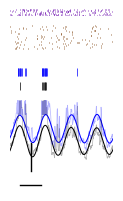

In [13]:
Vms = np.array(Vms)
print("Shape of Vm array:", Vms.shape)  # Should be (len(I_dep_values), N_neurons, time_steps)

closest_index = -1
cell_idx = 2  # Example cell index to plot
Vm_control = Vms[0, cell_idx]  # Vm for the first I_dep (control)
Vm_dep = Vms[closest_index, cell_idx]  # Vm for the I_dep closest to 20 Hz

spikes_control = spikes_all[0][cell_idx]  # Spikes for the first I_dep (control)
spikes_dep = spikes_all[closest_index][cell_idx]  # Spikes for the I_dep closest to 20 Hz

theta_Vm_control = theta_Vms[0][cell_idx]  # Theta Vm for the first I_dep (control)
theta_Vm_dep = theta_Vms[closest_index][cell_idx]  # Theta Vm for the I_dep closest to 20 Hz


# input_E_spikes = fixed_exc_times[fixed_exc_indices == cell_idx] / ms   # Spikes for the specific cell in E input
# input_I_spikes = fixed_inh_times[fixed_inh_indices == cell_idx] / ms  # Spikes for the specific cell in I input
# input_E_spikes = input_E_spikes[(input_E_spikes >= 100) & (input_E_spikes <= 1100)]
# input_I_spikes = input_I_spikes[(input_I_spikes >= 100) & (input_I_spikes <= 1100)]

# make the Vm_control and Vm_dep at spikes_control and spikes_dep become -20
# Vm_control[np.isin(t_array[1000:], spikes_control)] = -30
# Vm_dep[np.isin(t_array[1000:], spikes_dep)] = -30

width = 30/25.4 
height = 50/25.4 

sponcolor = '#5A5A5A'
inh_color = '#6A0DAD'
ext_color = '#7A3B03'


fig, ax = plt.subplots(3,1, figsize=(width,height), sharex=True, gridspec_kw={'height_ratios': [0.2, 0.8, 4]})


spike_times = np.array(exc_t_list[0])
neuron_indices = np.array(exc_i_list[0])
raster_data_exc = [spike_times[neuron_indices == i] for i in range(N_E_bg)]
all_ext_spikes =  np.sort(np.concatenate(raster_data_exc))


spike_times = np.array(inh_t_list[0])
neuron_indices = np.array(inh_i_list[0])
raster_data_inh = [spike_times[neuron_indices == i] for i in range(N_I_bg)]
all_inh_spikes =  np.sort(np.concatenate(raster_data_inh))


# plot the raster of raster_data_inh and raster_data_exc on ax[0] and ax[1]
ax[0].eventplot(raster_data_inh, linestyle='|', color=inh_color,  linelengths=1, linewidths=0.5)
ax[1].eventplot(raster_data_exc, linestyle='|', color=ext_color,  linelengths=1, linewidths=0.5)



t_array = np.linspace(0, duration, len(Vm_control))
ax[2].plot(t_array, theta_Vm_control + np.mean(Vm_control), color='k', linewidth=0.75)
ax[2].plot(t_array, theta_Vm_dep + np.mean(Vm_dep), color='b', linewidth=0.75)
ax[2].plot(t_array, Vm_control, color='k',linewidth=0.5, alpha=0.3)
ax[2].plot(t_array, Vm_dep, color='b',linewidth=0.5, alpha=0.3)
ax[2].eventplot(spikes_control, color='k', lineoffsets=-45, linelengths=3, linewidths=0.5)
ax[2].eventplot(spikes_dep, color='b', lineoffsets=-40, linelengths=3, linewidths=0.5)



# turn off all axes
for a in ax:
    a.axis('off')

#ax[0].legend(['Inh.', 'Ext.'], loc='upper right', fontsize=5, frameon=False, handlelength=1, bbox_to_anchor=(0.3, 2.2))

#ax[1].legend(['Ctrl.','Dep.'], loc='upper right', fontsize=5, frameon=False, handlelength=1, bbox_to_anchor=(0.3, 1.3))

# font ariel for legend
for a in ax:
    for item in ([a.title, a.xaxis.label, a.yaxis.label] +
             a.get_xticklabels() + a.get_yticklabels()):
        item.set_fontname('Arial')
        item.set_fontsize(5)
        

# plot a horizontal scale bar on the bottom axis
#ax[0].plot([-50,-50], [0,0.5], color='k',lw=1)

ax[2].plot([600,600], [-75, -65], color='k',lw=1)

#ax[2].plot([-50,-50], [-70, -50], color='k',lw=1)

ax[2].plot([550, 650], [-80, -80], color='k',lw=1)

ax[2].set_xlim(500, 1000)

#ax[1].set_ylim(-80, 20)
# adjust vertical space between subplots
plt.subplots_adjust(hspace=0.45)
        
# tight layout
fig.tight_layout()
#ax[2].text(50, -85, '100 ms', ha='center', va='top', fontsize=5)

fig.savefig('Exc_theta_low_example_highNMDA.pdf',dpi=300, bbox_inches='tight')

# calculate power spectral density of v4 using Welch's method, max freq = 100 Hz
fs = 1/(dt/1000)  # for example, 1000 Hz

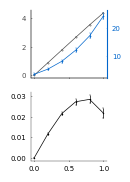

In [9]:
import numpy as np
import matplotlib.pyplot as plt



# --- Figure Setup ---
# Convert mm to inches for figsize
width = 25 / 25.4 
height = 50 / 25.4 
fig, axes = plt.subplots(2,1,figsize=(width, height), sharex=True)

# --- Plot 1: Depression Data (Left Y-axis) ---
# Calculate mean and standard error of the mean (SEM)
dep_all = np.array(v_values)
dep_all = dep_all - dep_all[0, :]  # Subtract the first column (control) from all columns
fr_stim_all = np.array(firing_rates_values) 
# subtract v_values[]
mean_dep = np.mean(dep_all, axis=1)
sem_dep = np.std(dep_all, axis=1) / np.sqrt(dep_all.shape[1])

ax = axes[0]  # Use the first subplot for depression data
# Plotting mean and error bars in one call
ax.errorbar(
    I_deps/1000,
    mean_dep,
    yerr=sem_dep,
    fmt='-o',          # Format string for line and markers
    color='#4C4C4C',   # A dark gray for good contrast
    linewidth=0.5,
    markersize=0.25,
    capthick=0.25,
    capsize=1,         # Adds caps to error bars
    label='Depression (no NMDA)'
)

#ax.set_yticks([0, 4,8])
# --- Plot 2: Firing Rate Data (Right Y-axis) ---
# Create a second y-axis that shares the same x-axis
ax2 = ax.twinx()
mean_fr = np.mean(fr_stim_all, axis=1)
sem_fr = np.std(fr_stim_all, axis=1) / np.sqrt(fr_stim_all.shape[1])

ax2.errorbar(
    I_deps/1000,
    mean_fr,
    yerr=sem_fr,
    fmt='-s',          # Using squares for a different marker
    color='#0066CC',   # A distinct blue
    linewidth=0.5,
    markersize=0.25,
    capthick=0.25,
    capsize=1,
    label='Firing Rate (no NMDA)'
)



# all font size is set to 5
plt.rcParams.update({'font.size': 5})
# font set to sans-serif
plt.rcParams.update({'font.family': 'sans-serif'})


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25) 
ax.spines['bottom'].set_linewidth(0.25) 
#axtemp.autoscale(enable=True, axis='both')
ax.tick_params(direction='in', which='both', length=0.5, width=0.5,labelsize=5)
#ax.set_yticks([0,4,8])

ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(0.25)
ax2.spines['bottom'].set_linewidth(0.25)
ax2.tick_params(direction='in', which='both', length=0.5, width=0.5,labelsize=5)

# ax2 color = '#0066CC'  # Set the color of the second y-axis
ax2.tick_params(axis='y', labelcolor='#0066CC')

# set ax2 ticks color
ax2.yaxis.set_tick_params(color='#0066CC')

ax.tick_params(axis='y', labelcolor='#4C4C4C')

# ax2 right spines color = '#0066CC'
ax2.spines['right'].set_color('#0066CC')



ax = axes[1]  # Use the second subplot for theta amplitude data
# Calculate mean and standard error of the mean (SEM)
theta_amp_ratio_all = np.array(theta_modulation_Vm)
mean_theta_amp = np.mean(theta_amp_ratio_all, axis=1)
sem_theta_amp = np.std(theta_amp_ratio_all, axis=1)  / np.sqrt(theta_amp_ratio_all.shape[1])
# Plotting mean and error bars in one call
ax.errorbar(
    I_deps/1000,
    mean_theta_amp,
    yerr=sem_theta_amp,
    fmt='-^',          # Format string for line and markers
    color='k',   # A distinct orange
    linewidth=0.5,
    markersize=0.25,
    capthick=0.25,
    capsize=1,         # Adds caps to error bars
    label='Theta Amplitude Ratio (no NMDA)'
)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.25) 
ax.spines['bottom'].set_linewidth(0.25) 
#axtemp.autoscale(enable=True, axis='both')
ax.tick_params(direction='in', which='both', length=0.5, width=0.5,labelsize=5)

#ax.set_xticks([0, 0.15,0.3])
#ax.set_yticks([0, 0.1, 0.2, 0.3])


# ax4 = ax.twinx()

# theta_amp_ratio_all2 = np.array(theta_modulation_Vm2)
# mean_theta_amp2 = np.mean(theta_amp_ratio_all2, axis=1)
# sem_theta_amp2 = np.std(theta_amp_ratio_all2, axis=1)  / np.sqrt(theta_amp_ratio_all2.shape[1])

# ax4.errorbar(
#     I_deps,
#     mean_theta_amp2,
#     yerr=sem_theta_amp2,
#     fmt='-s',          # Using squares for a different marker
#     color='#0066CC',   # A distinct blue
#     linewidth=0.5,
#     markersize=0.25,
#     capthick=0.25,
#     capsize=1,
#     label='Firing Rate (no NMDA)'
# )

# all font size is set to 5
plt.rcParams.update({'font.size': 5})
# all font ariel
plt.rcParams.update({'font.family': 'Arial'})




# save the figure
#plt.tight_layout()
plt.savefig('firing_rate_plot_E_low_highNMDA.pdf', dpi=300, bbox_inches='tight')

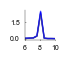

In [10]:
# calculat psd 
def calc_PSD_nospike(trace,fr,nuMax=100,nuMin=0.1):
    trace = trace - np.mean(trace)
    # calculate power spectral density
    freq=np.arange(0,trace.size)*fr/trace.size
    sMax = np.where(freq > nuMax)[0][0]
    sMin = np.where(freq > nuMin)[0][0]
    psd=np.multiply(fft(trace),np.conj(fft(trace)))
    psd = np.real(psd)
    # normalize by psd between 1 to 500 Hz
    #psd = psd / np.sum(psd[(freq >= 1) & (freq <= 500)])
    return psd[sMin:sMax],freq[sMin:sMax]

def plot_psd(frequencies, psd_spon, psd_stim, ax):

    sponcolor = '#5A5A5A'
    inh_color = '#6A0DAD'
    ext_color = '#F4C430'
    ax.plot(frequencies, np.mean(psd_spon,0)*1e-9, color=sponcolor, linewidth=0.5)
    ax.plot(frequencies, np.mean(psd_stim,0)*1e-9, color='blue', linewidth=0.5)


    # shade the error (sem)
    sem_spon = np.std(psd_spon,0)/np.sqrt(len(psd_spon))
    sem_stim = np.std(psd_stim,0)/np.sqrt(len(psd_stim))
    ax.fill_between(frequencies, (np.mean(psd_spon,0)-sem_spon)*1e-9, (np.mean(psd_spon,0)+sem_spon)*1e-9, color=sponcolor, alpha=0.5)
    ax.fill_between(frequencies, (np.mean(psd_stim,0)-sem_stim)*1e-9, (np.mean(psd_stim,0)+sem_stim)*1e-9, color='blue', alpha=0.5)

    # legend top right
    #ax.legend(loc='upper right')
    # set x axis base 2 log scale
    #ax.set_xscale('log', base=2)
    #ax.set_xlabel('Frequency (Hz)')
    #ax.set_ylabel('Power')
    # set x axis ticks [1,8,64]
    # ax.set_xticks([2,4,8,16,32,64])
    # # set x axis tick labels [1,8,64]
    # ax.set_xticklabels([2,4,8,16,32,64])

    ax.set_xticks([6,8,10])
    ax.set_xticklabels([6,8,10])

    # set y axis scientific notation
    #ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

    # all font size is set to 5
    plt.rcParams.update({'font.size': 5})
    # font set to sans-serif
    plt.rcParams.update({'font.family': 'sans-serif'})


    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.25) 
    ax.spines['bottom'].set_linewidth(0.25) 
    #axtemp.autoscale(enable=True, axis='both')
    ax.tick_params(direction='in', which='both', length=0.5, width=0.5,labelsize=5)

    # axis tight
    ax.set_xlim([6,10])

    # y ticks are integers
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2))

psd_spon = []
psd_stim = []


for Vmtemp in Vms[0, :]:
    psd, freq = calc_PSD_nospike(Vmtemp, 10000)
    psd_spon.append(psd)

for Vmtemp in Vms[closest_index, :]:
    psd, freq = calc_PSD_nospike(Vmtemp, 10000)
    psd_stim.append(psd)

width = 10/25.4 
height = 10/25.4 
fig, ax = plt.subplots(1,1, figsize=(width,height))


plot_psd(frequencies=freq, psd_spon=np.array(psd_spon), psd_stim=np.array(psd_stim), ax=ax)
#ax.legend(['',''],loc='upper right', frameon=False, fancybox=False,fontsize=5,handlelength=1,handleheight=1)


# ariel 
plt.rcParams.update({'font.size': 5})
plt.rcParams.update({'font.family': 'Arial'})

#plt.tight_layout()
import os 
fig.savefig(os.path.join('.', 'psd_Itheta_low_highNMDA.pdf'), dpi=300)
